In [1]:
import kagglehub
landrykezebou_vcor_vehicle_color_recognition_dataset_path = kagglehub.dataset_download('landrykezebou/vcor-vehicle-color-recognition-dataset')

print(landrykezebou_vcor_vehicle_color_recognition_dataset_path)

100%|██████████| 574M/574M [00:04<00:00, 148MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/landrykezebou/vcor-vehicle-color-recognition-dataset/versions/1


# Dataset Reorganization

In [8]:
import os
import shutil

In [14]:
original_dataset_path = "/root/.cache/kagglehub/datasets/landrykezebou/vcor-vehicle-color-recognition-dataset/versions/1/"
original_train = os.path.join(original_dataset_path, "train")
original_val = os.path.join(original_dataset_path, "val")
original_test = os.path.join(original_dataset_path, "test")

In [10]:
binary_train = "/content/binary_dataset/train"
binary_val = "/content/binary_dataset/val"
binary_test = "/content/binary_dataset/test"

In [11]:
for split in [binary_train, binary_val, binary_test]:
    os.makedirs(os.path.join(split, "blue"), exist_ok=True)
    os.makedirs(os.path.join(split, "not_blue"), exist_ok=True)

In [12]:
def reorganize(original_path, new_path):
    for class_name in os.listdir(original_path):
        class_folder = os.path.join(original_path, class_name)
        if not os.path.isdir(class_folder):
            continue
        target_class = "blue" if class_name.lower() == "blue" else "not_blue"
        for img_file in os.listdir(class_folder):
            src = os.path.join(class_folder, img_file)
            dst = os.path.join(new_path, target_class, img_file)
            shutil.copy(src, dst)

In [15]:
reorganize(original_train, binary_train)
reorganize(original_val, binary_val)
reorganize(original_test, binary_test)

In [16]:
print("✅ Dataset reorganized into 'blue' and 'not_blue'")

✅ Dataset reorganized into 'blue' and 'not_blue'


# Train Binary Classifier

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [ ]:
train_dir = binary_train
val_dir = binary_val

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=(128, 128), batch_size=32, class_mode='binary'
)

Found 7262 images belonging to 2 classes.
Found 1549 images belonging to 2 classes.


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.9221 - loss: 0.1698 - val_accuracy: 0.9845 - val_loss: 0.0519
Epoch 2/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.9802 - loss: 0.0610 - val_accuracy: 0.9671 - val_loss: 0.0817
Epoch 3/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.9832 - loss: 0.0502 - val_accuracy: 0.9852 - val_loss: 0.0506
Epoch 4/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.9860 - loss: 0.0410 - val_accuracy: 0.9897 - val_loss: 0.0385
Epoch 5/5
227/227 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.9920 - loss: 0.0277 - val_accuracy: 0.9877 - val_loss: 0.0379


In [ ]:
model.save("blue_car_classifier.keras")

from google.colab import files

files.download("blue_car_classifier.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluation

In [17]:
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

COLOR_MODEL_PATH = "/content/blue_car_classifier.keras"
DATASET_DIR = "/content/binary_dataset/test/"
COLOR_CLASSES = ["blue", "not_blue"]
THRESHOLD = 0.5
IMG_SIZE = (128, 128)

model = load_model(COLOR_MODEL_PATH)

In [24]:
y_true = []
y_pred = []
y_prob = []

for label_idx, label_name in enumerate(COLOR_CLASSES):
    folder = os.path.join(DATASET_DIR, label_name)
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        pred = model.predict(img_array, verbose=0)
        y_prob.append(pred[0][0])

        if pred.shape[-1] == 1:
            pred_label = 1 if pred[0][0] > THRESHOLD else 0
        else:
            pred_label = np.argmax(pred)

        y_true.append(label_idx)
        y_pred.append(pred_label)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

In [22]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [26]:
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, pos_label=0) * 100
recall = recall_score(y_true, y_pred, pos_label=0) * 100
f1 = f1_score(y_true, y_pred, pos_label=0) * 100
roc_auc = roc_auc_score(y_true, y_prob) * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision (blue): {precision:.2f}%")
print(f"Recall (blue): {recall:.2f}%")
print(f"F1 Score (blue): {f1:.2f}%")
print(f"ROC-AUC: {roc_auc:.2f}%\n")

Accuracy: 98.33%
Precision (blue): 90.30%
Recall (blue): 93.71%
F1 Score (blue): 91.98%
ROC-AUC: 99.75%



In [27]:
report = classification_report(y_true, y_pred, target_names=['blue', 'not_blue'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

        blue       0.90      0.94      0.92       159
    not_blue       0.99      0.99      0.99      1396

    accuracy                           0.98      1555
   macro avg       0.95      0.96      0.96      1555
weighted avg       0.98      0.98      0.98      1555



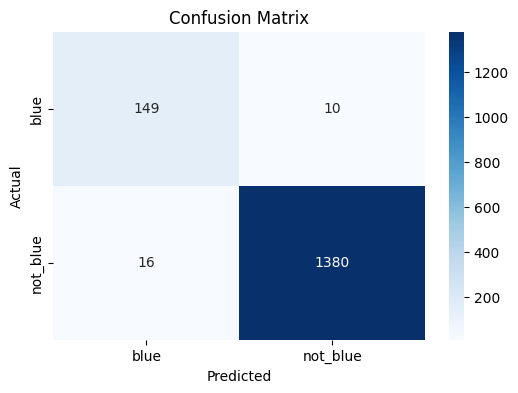

In [28]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['blue','not_blue'], yticklabels=['blue','not_blue'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

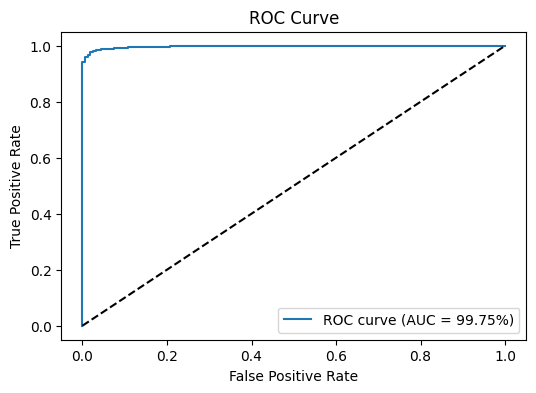

In [29]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f}%)')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()